In [1]:
import score_functions as sf
import pandas as pd
import numpy as np
import networkx as nx
import pathway_analysis as pa
import pickle
import itertools
import os
import random
#submmodules
from matplotlib import pyplot as plt



In [2]:
G = nx.read_gpickle('data/protein_graph')

In [3]:
pa.print_graph_properties(G)

Number of nodes: 6144
Number of edges: 338441
Density: 0.018
Is connected: True
Number of connected components: 1
Largest connected component: 6144 (1.00%)
Number of isolated nodes: 0 (0.00%)
Number of self loops: 0


In [3]:
with open('data/communities.pickle', 'rb') as f:
    cs = pickle.load(f)

### Define an ordering for disease and target genes

In [5]:
aliases = pa.get_biogrid_aliases()

In [6]:
df_dis_genes = pd.read_csv('disease-gene.csv')
df_dis_genes['gene_name'] = df_dis_genes['gene_name'].apply(
    lambda x: aliases[x] if aliases.get(x) is not None else x)

In [7]:
# List of all the disease nodes
dis_genes = list(df_dis_genes['gene_name'])

In [8]:
# dis_gene_order is a dictionary containing, for all the dis_genes its order.
dis_genes_order = {}
count = 0
for disease, data in df_dis_genes.groupby('disease'):
    for gene_name in data['gene_name']:
        dis_genes_order[gene_name] = count
        count += 1

In [9]:
# The same holds for tar
tar_genes = [n for n, target in G.nodes(data='target') if target]
tar_genes_order = {x: i for i, x in enumerate(tar_genes)}

In [10]:
row_partitioning = []
for dis, data in df_dis_genes.groupby('disease'):
    a = [dis_genes_order[gene] for gene in data['gene_name'] if gene in dis_genes_order]
    row_partitioning.append(a[-1])

In [11]:
ncm_lengths = [len(cs.to_node_community_map()[gene]) for gene in G.nodes()]

In [12]:
lower_perc = np.percentile(ncm_lengths, 75)
upper_perc = np.percentile(ncm_lengths, 95)

### Compute scores

In [13]:
if os.path.isfile('data/node_index'):
    with open('data/node_index', 'rb') as f:
        node_index = pickle.load(f)
else:
    node_index = {n: i for i, n in enumerate(G.nodes())}

if os.path.isfile('data/shortest_path_matrix.npy'):
    shortest_path_matrix = np.load('data/shortest_path_matrix.npy')
    diameter = shortest_path_matrix.max()
else:
    shortest_path_matrix = np.zeros([len(G.nodes()), len(G.nodes())], dtype=int)
    for source, dict_target in nx.all_pairs_shortest_path_length(G):
        for target in dict_target.keys():
            shortest_path_matrix[node_index[source], node_index[target]] = dict_target[target]
    diameter = np.max(shortest_path_matrix)

### Exponential decay score

In [14]:
scores_exponential_decay = np.zeros([len(dis_genes), len(tar_genes)])
precomputed_scores = {}
for dis, tar in itertools.product(dis_genes, tar_genes):
    n_mod_dis = len(cs.to_node_community_map()[dis])
    if n_mod_dis > upper_perc:
        sample_dis = random.randint(lower_perc, upper_perc)
    else:
        sample_dis = None
    
    n_mod_tar = len(cs.to_node_community_map()[tar])
    if n_mod_tar > upper_perc:
        sample_tar = random.randint(lower_perc, upper_perc)
    else:
        sample_tar = None

    score = sf.best_score(cs, dis, tar, min=False, score_function=sf.exponential_decay_score,
                       shortest_path_matrix=shortest_path_matrix, sample_dis=sample_dis, sample_tar=sample_tar,
                       node_index=node_index, precomputed_scores=precomputed_scores)
    scores_exponential_decay[dis_genes_order[dis], tar_genes_order[tar]] = score

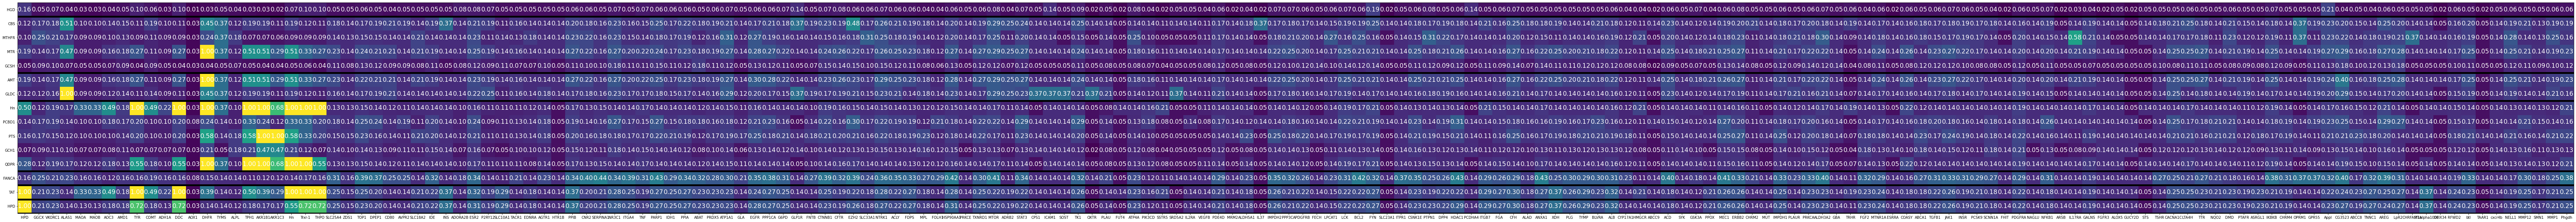

In [15]:
sf.show_score_matrix(scores_exponential_decay, tar_genes_order, dis_genes_order, row_partitioning)

### Average shortest distance score

In [16]:
scores_average_shortest_path = np.zeros([len(dis_genes), len(tar_genes)])
precomputed_scores = {}
for dis, tar in itertools.product(dis_genes, tar_genes):
    n_mod_dis = len(cs.to_node_community_map()[dis])
    if n_mod_dis > upper_perc:
        sample_dis = random.randint(lower_perc, upper_perc)
    else:
        sample_dis = None
    
    n_mod_tar = len(cs.to_node_community_map()[tar])
    if n_mod_tar > upper_perc:
        sample_tar = random.randint(lower_perc, upper_perc)
    else:
        sample_tar = None

    score = sf.best_score(cs, dis, tar, min=False, score_function=sf.D,
                          shortest_path_matrix=shortest_path_matrix,
                          sample_dis=sample_dis, sample_tar=sample_tar,
                          node_index=node_index, precomputed_scores=precomputed_scores, diameter=diameter)
    scores_average_shortest_path[dis_genes_order[dis], tar_genes_order[tar]] = score

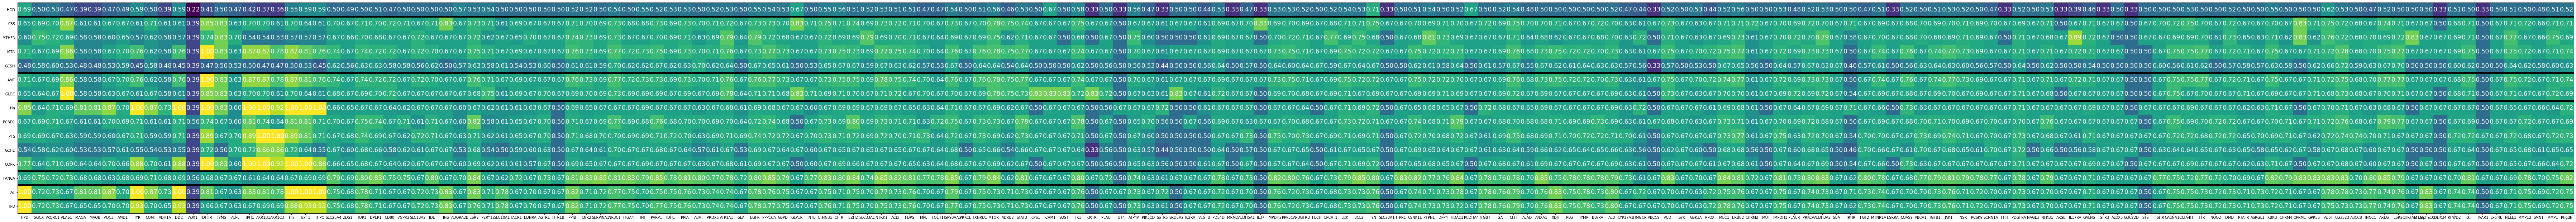

In [17]:
sf.show_score_matrix(scores_average_shortest_path, tar_genes_order, dis_genes_order, row_partitioning)

In [18]:
# Shortest path matrix
np.save('data/shortest_path_matrix', shortest_path_matrix)

# Node index
with open('data/node_index', 'wb') as f:
    pickle.dump(node_index, f)

# Score matrices
with open('scores/exponential_decay_score.pickle', 'wb') as f:
    pickle.dump(scores_exponential_decay, f)
with open('scores/average_shortest_path_score.pickle', 'wb') as f:
    pickle.dump(scores_average_shortest_path, f)